# Evaluating cloud dilation options for Landsat Fmask <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[ga_ls9c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls9c_ard_3)



## Getting started

### Load packages
Import Python packages used for the analysis.


In [2]:
import datacube
from datacube.utils.masking import make_mask
from odc.algo import mask_cleanup
from datacube.utils.geometry import CRS, Geometry, GeoBox

import sys
import fiona
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sys.path.insert(1, "../Tools/")
from dea_tools.dask import create_local_dask_cluster

# Launch Dask cluster
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/james.miller@ga.gov.au/proxy/8787/status,
Dashboard: /user/james.miller@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 3,Total memory: 28.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36361,Workers: 1
Dashboard: /user/james.miller@ga.gov.au/proxy/8787/status,Total threads: 3
Started: Just now,Total memory: 28.21 GiB
Comm: tcp://127.0.0.1:33577,Total threads: 3
Dashboard: /user/james.miller@ga.gov.au/proxy/34707/status,Memory: 28.21 GiB
Nanny: tcp://127.0.0.1:35015,


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [3]:
dc = datacube.Datacube(app="Cloud_dilation-analysis")

### Assumptions

In [47]:
start_buffering = 0
end_buffering = 20
bands = ["nbart_blue", "nbart_red", "nbart_green", "nbart_nir", "nbart_swir_1", "nbart_swir_2", "oa_fmask"]
products = ["ga_ls5t_ard_3", "ga_ls7e_ard_3", "ga_ls8c_ard_3", "ga_ls9c_ard_3"]
maturity = "final"
time_period = ('2015-01-01', '2015-05-01')
landsat_shape = "ga_ls_path_row_grid.geojson"
path_row_list_full = ["113082", "111077", "108083", "108079", "105069", "103073", "099079", "098077", "097081", "095082", "094085", "093086", "096072", "091090", "090086",
                "090084", "090085", "091079", "090084", "089084", "090079", "089079"]
# smaller path row list for testing purposes
path_row_list = ["113082", "111077"]

### Load Landsat Scene Poly

In [37]:
def landsat_scene_poly(landsat_shape, path_row):
    '''
    Get geometry for a given landsat path row
    
    Parameters
    ----------    
    landsat_shape : string
        location of landsat path row shapefile or geojson
    path_row : string
        Path row to search for

        
    Returns
    -------
    geometry : geometry
        geopolygon for given path row
    '''
    with fiona.open(landsat_shape) as all_shapes:
        for s in all_shapes:
            # landsat pathrows dont include 0 in front hence convert path-row to int to drop 0
            if s['properties'].get('PR') == str(int(path_row)):
                return Geometry(s['geometry'], crs=CRS('EPSG:4326'))

### Select spatiotemporal query

In [42]:
# for full path-row geopolygon
def query_params(landsat_shape, path_row, time_period):
    '''
    Create query params for odc load
    
    Parameters
    ----------    
    landsat_shape : string
        location of landsat path row shapefile or geojson
    path_row : string
        Path row to search for
    time_period : list
        Time range

        
    Returns
    -------
    query_params : dictionary
        qury params to use for odc load
    '''
    query_poly = landsat_scene_poly(landsat_shape, path_row)
    query_params = {
        'geopolygon': query_poly,
        'time': time_period,
        'region_code': path_row,
    }
    return query_params

# for small scale fast tests
def query_params_lat_lon_test(time_period):
    query_params = dict(x=(140, 140.1), y=(-30, -30.1), time=time_period)
    return query_params

## Load data


In [43]:
def load_data(bands, products, query_params):
    '''
    Load odc data
    
    Parameters
    ----------    
    bands : string
        measurement bands
    products : string
        odc products
    query_params: dictionary
        odc query parameters

        
    Returns
    -------
    ds : dataset
        geospatial satellite data dataset
    '''
    # Set load params (measurements to load, Dask chunking, resampling etc)
    load_params = dict(measurements=bands, group_by='solar_day', dask_chunks={})

    # Lazily load data
    ds = dc.load(product=products, **query_params, **load_params)
    
    return ds

## Fmask cloud and shadow mask
Based on content from: https://docs.dea.ga.gov.au/notebooks/How_to_guides/Masking_data.html

In [44]:
def calc_cloud_shadow_mask(ds):
    '''
    Calculate cloud shadow mask
    
    Parameters
    ----------    
    ds : dataset
        data

        
    Returns
    -------
    cloud_shadow_mask : dataset
        cloud shadow mask
    '''
    # Identify pixels that are either "cloud" or "cloud_shadow"
    cloud_shadow_mask = make_mask(ds.oa_fmask, fmask="cloud") | make_mask(
        ds.oa_fmask, fmask="shadow"
    )
    return cloud_shadow_mask

# Plot
#cloud_shadow_mask.isel(time=slice(4, 12)).plot(col="time", col_wrap=4)

### Applying dilation using `mask_cleanup`

In [45]:
def get_std(buffer_size, ds, cloud_shadow_mask): 
    '''
    Calculate standard deviation
    
    Parameters
    ----------    
    buffer_size : integer
        pixel buffer size
    ds : dataset
        odc data
    cloud_shadow_mask: dataset
        cloud shadow mask

        
    Returns
    -------
    nbart_blue_std, nbart_red_std, nbart_green_std, nbart_nir_std, nbart_swir_1_std, nbart_swir_2_std : integer
        standard deviation integer
    '''
    # Dilate all cloud and cloud shadow pixels by n pixels (uses a circular disk)
    cloud_shadow_buffered = mask_cleanup(
        mask=cloud_shadow_mask, mask_filters=[("dilation", buffer_size)]
    )
    
    # Apply the mask
    clear_buffered = ds.where(~cloud_shadow_buffered)
    
    # load into memory
    clear_buffered.load()

    nbart_red_std = int(clear_buffered.nbart_red.std("time").mean())
    nbart_blue_std = int(clear_buffered.nbart_blue.std("time").mean())
    nbart_green_std = int(clear_buffered.nbart_green.std("time").mean())
    nbart_nir_std = int(clear_buffered.nbart_nir.std("time").mean())
    nbart_swir_1_std = int(clear_buffered.nbart_swir_1.std("time").mean())
    nbart_swir_2_std = int(clear_buffered.nbart_swir_2.std("time").mean())
    
    return nbart_blue_std, nbart_red_std, nbart_green_std, nbart_nir_std, nbart_swir_1_std, nbart_swir_2_std

def std_buffer_comp(start_buffering, end_buffering, ds, cloud_shadow_mask, path_row):
    '''
    Calculate buffer comparison standard deviation
    
    Parameters
    ----------    
    start_buffering, end_buffering : integer
        pixel buffer size
    ds : dataset
        odc data
    cloud_shadow_mask: dataset
        cloud shadow mask
    path_row: string
        landsat path row string

        
    Returns
    -------
    std_buffer_df : pandas dataframe
        dataframe containing standard deviation per buffer pixel per band
    '''
    nbart_blue_buffer_std = {}
    nbart_red_buffer_std = {}
    nbart_green_buffer_std = {}
    nbart_nir_buffer_std = {}
    nbart_swir_1_buffer_std = {}
    nbart_swir_2_buffer_std = {}

    for buffer in range(start_buffering, end_buffering):    
        nbart_blue_buffer_std[buffer],  nbart_red_buffer_std[buffer], nbart_green_buffer_std[buffer], nbart_nir_buffer_std[buffer], nbart_swir_1_buffer_std[buffer], nbart_swir_2_buffer_std[buffer] = get_std(buffer, ds, cloud_shadow_mask)
        print(f"Buffer in pixels: {buffer}, nbart_blue_std: {nbart_blue_buffer_std[buffer]}, nbart_red_std: {nbart_red_buffer_std[buffer]}, nbart_green_std: {nbart_green_buffer_std[buffer]}, nbart_nir_std: {nbart_nir_buffer_std[buffer]}, nbart_swir_1_std: {nbart_swir_1_buffer_std[buffer]}, nbart_swir_2_std: {nbart_swir_2_buffer_std[buffer]}")

    std_buffer_d = {
        'pixel_buffer': range(start_buffering, end_buffering),
        'nbart_blue_std': nbart_blue_buffer_std.values(),
        'nbart_red_std': nbart_red_buffer_std.values(),
        'nbart_green_std': nbart_green_buffer_std.values(),
        'nbart_nir_std': nbart_nir_buffer_std.values(),
        'nbart_swir_1_std': nbart_swir_1_buffer_std.values(),
        'nbart_swir_2_std': nbart_swir_2_buffer_std.values()
    }
    std_buffer_df = pd.DataFrame(data=std_buffer_d)

    return std_buffer_df

### Plot standard deviation vs buffer size in pixels

In [19]:
def plot_std_vs_buffer(std_buffer_df, path_row):
    plt.title(f"Standard Devation Gradient per Buffer Pixel for {path_row}", size=15)
    plt.xlabel("buffer distance")
    plt.ylabel("std")
    plt.scatter(std_buffer_df['pixel_buffer'].tolist(), std_buffer_df['nbart_blue_std'].tolist())
    plt.scatter(std_buffer_df['pixel_buffer'].tolist(), std_buffer_df['nbart_red_std'].tolist())
    plt.scatter(std_buffer_df['pixel_buffer'].tolist(), std_buffer_df['nbart_green_std'].tolist())
    plt.scatter(std_buffer_df['pixel_buffer'].tolist(), std_buffer_df['nbart_nir_std'].tolist())
    plt.scatter(std_buffer_df['pixel_buffer'].tolist(), std_buffer_df['nbart_swir_1_std'].tolist())
    plt.scatter(std_buffer_df['pixel_buffer'].tolist(), std_buffer_df['nbart_swir_2_std'].tolist())
    plt.show()
    
    plt.plot(std_buffer_df['pixel_buffer'].tolist(), std_buffer_df['nbart_blue_std'].tolist())
    plt.plot(std_buffer_df['pixel_buffer'].tolist(), std_buffer_df['nbart_red_std'].tolist())
    plt.plot(std_buffer_df['pixel_buffer'].tolist(), std_buffer_df['nbart_green_std'].tolist())
    plt.plot(std_buffer_df['pixel_buffer'].tolist(), std_buffer_df['nbart_nir_std'].tolist())
    plt.plot(std_buffer_df['pixel_buffer'].tolist(), std_buffer_df['nbart_swir_1_std'].tolist())
    plt.plot(std_buffer_df['pixel_buffer'].tolist(), std_buffer_df['nbart_swir_2_std'].tolist())
    plt.show()

### Plot the gradient of above for all bands

In [46]:
def plot_gradient_std(std_buffer_df, path_row, product):
    '''
    Plot differentiation/gradient of standard deviation
    
    Parameters
    ----------    
    std_buffer_df : pandas dataframe
        dataframe containing standard deviation per buffer pixel per band
    path_row: string
        landsat path row string
    product: string
        odc product
    '''
    # Plot all bands
    y_blue = np.array(std_buffer_df['nbart_blue_std'].tolist(), dtype=np.float64)
    j_blue = np.gradient(y_blue)
    x = std_buffer_df['pixel_buffer'].tolist()

    y_red = np.array(std_buffer_df['nbart_red_std'].tolist(), dtype=np.float64)
    j_red = np.gradient(y_red)

    y_green = np.array(std_buffer_df['nbart_green_std'].tolist(), dtype=np.float64)
    j_green = np.gradient(y_green)

    y_nir = np.array(std_buffer_df['nbart_nir_std'].tolist(), dtype=np.float64)
    j_nir = np.gradient(y_nir)

    y_swir_1 = np.array(std_buffer_df['nbart_swir_1_std'].tolist(), dtype=np.float64)
    j_swir_1 = np.gradient(y_swir_1)

    y_swir_2 = np.array(std_buffer_df['nbart_swir_2_std'].tolist(), dtype=np.float64)
    j_swir_2 = np.gradient(y_swir_2)

    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(x, j_blue, label='nbart_blue')
    plt.plot(x, j_red, label='nbart_red')
    plt.plot(x, j_green, label='nbart_green')
    plt.plot(x, j_nir, label='nbart_nir')
    plt.plot(x, j_swir_1, label='nbart_swir_1')
    plt.plot(x, j_swir_2, label='nbart_swir_2')

    plt.xlabel("Buffer Pixels", size=12)
    plt.ylabel("Standard Deviation Gradient", size=12)
    plt.title(f"Standard Devation Gradient per Buffer Pixel for {path_row} {product}", size=15)
    for index in range(len(x)):
      ax.text(x[index], j_blue[index], j_blue[index], size=12)
    plt.grid()
    plt.xticks([i for i in range(20)], size=12)
    plt.legend()
    plt.show()
    # plt.savefig(f"output_data/{path_row}_{product}_std_gradient")
    
    # calculate mean of all bands
    j_mean = np.mean(np.array([j_blue, j_red, j_green, j_nir, j_swir_1, j_swir_2]), axis=0)
    fig, ax = plt.subplots(figsize=(12,8))
    plt.plot(x, j_mean, label='mean_all_bands')
    plt.xlabel("Buffer Pixels", size=12)
    plt.ylabel("Standard Deviation Gradient", size=12)
    plt.title(f"Standard Devation Gradient Mean All Bands per Buffer Pixel for {path_row} {product}", size=15)
    for index in range(len(x)):
      ax.text(x[index], j_blue[index], j_blue[index], size=12)
    plt.grid()
    plt.xticks([i for i in range(20)], size=12)
    plt.legend()
    plt.show()
    # Enable below to save plot
    # plt.savefig(f"output_data/{path_row}_{product}_std_gradient_mean")

## Run Cloud Buffering Analysis for all selected validation products and path-rows

Error - possibly no data for ga_ls5t_ard_3. 'Dataset' object has no attribute 'oa_fmask'
Buffer in pixels: 0, nbart_blue_std: 480, nbart_red_std: 784, nbart_green_std: 615, nbart_nir_std: 996, nbart_swir_1_std: 1200, nbart_swir_2_std: 1010
Buffer in pixels: 1, nbart_blue_std: 422, nbart_red_std: 729, nbart_green_std: 559, nbart_nir_std: 933, nbart_swir_1_std: 1136, nbart_swir_2_std: 959
Buffer in pixels: 2, nbart_blue_std: 379, nbart_red_std: 670, nbart_green_std: 507, nbart_nir_std: 855, nbart_swir_1_std: 1055, nbart_swir_2_std: 890
Buffer in pixels: 3, nbart_blue_std: 362, nbart_red_std: 647, nbart_green_std: 487, nbart_nir_std: 823, nbart_swir_1_std: 1021, nbart_swir_2_std: 861
Buffer in pixels: 4, nbart_blue_std: 352, nbart_red_std: 632, nbart_green_std: 475, nbart_nir_std: 803, nbart_swir_1_std: 1000, nbart_swir_2_std: 842
Buffer in pixels: 5, nbart_blue_std: 341, nbart_red_std: 616, nbart_green_std: 462, nbart_nir_std: 780, nbart_swir_1_std: 974, nbart_swir_2_std: 820
Buffer in p

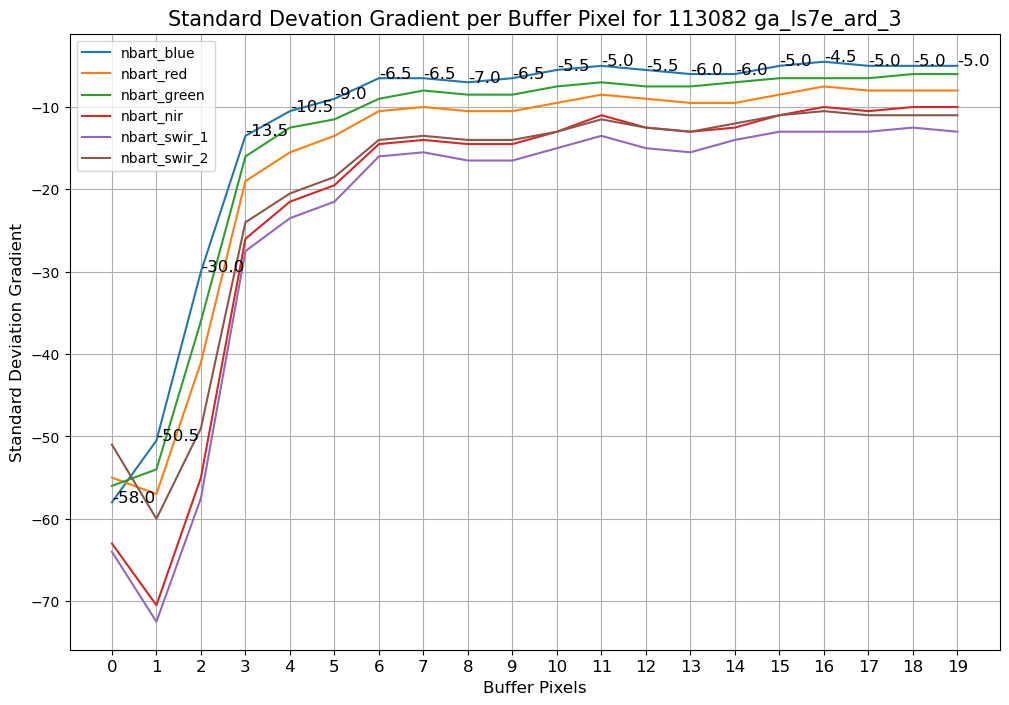

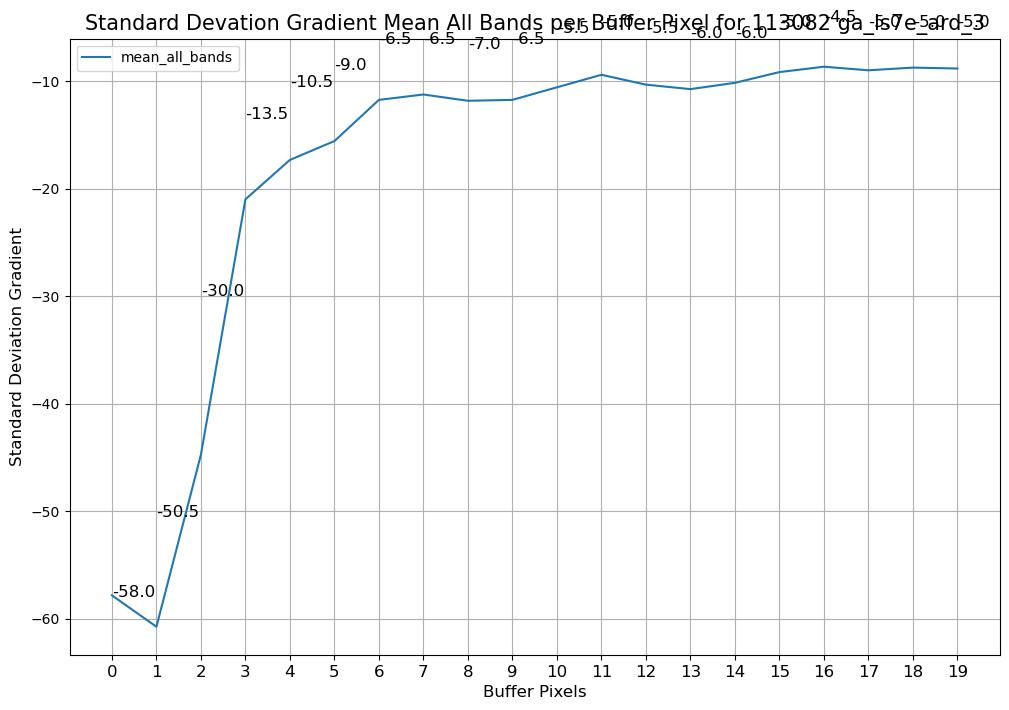

Buffer in pixels: 0, nbart_blue_std: 102, nbart_red_std: 238, nbart_green_std: 140, nbart_nir_std: 201, nbart_swir_1_std: 296, nbart_swir_2_std: 274
Buffer in pixels: 1, nbart_blue_std: 93, nbart_red_std: 226, nbart_green_std: 130, nbart_nir_std: 180, nbart_swir_1_std: 275, nbart_swir_2_std: 257
Buffer in pixels: 2, nbart_blue_std: 87, nbart_red_std: 218, nbart_green_std: 123, nbart_nir_std: 167, nbart_swir_1_std: 263, nbart_swir_2_std: 247
Buffer in pixels: 3, nbart_blue_std: 82, nbart_red_std: 211, nbart_green_std: 117, nbart_nir_std: 156, nbart_swir_1_std: 252, nbart_swir_2_std: 239
Buffer in pixels: 4, nbart_blue_std: 79, nbart_red_std: 206, nbart_green_std: 112, nbart_nir_std: 148, nbart_swir_1_std: 244, nbart_swir_2_std: 232
Buffer in pixels: 5, nbart_blue_std: 75, nbart_red_std: 200, nbart_green_std: 108, nbart_nir_std: 139, nbart_swir_1_std: 234, nbart_swir_2_std: 225
Buffer in pixels: 6, nbart_blue_std: 73, nbart_red_std: 196, nbart_green_std: 105, nbart_nir_std: 133, nbart_sw

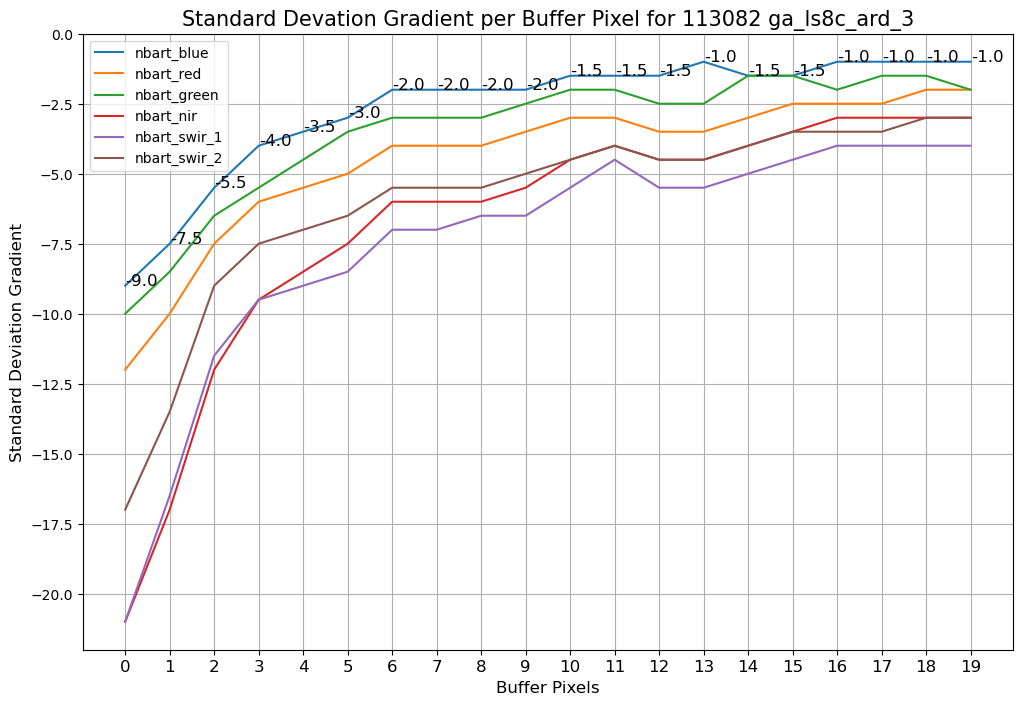

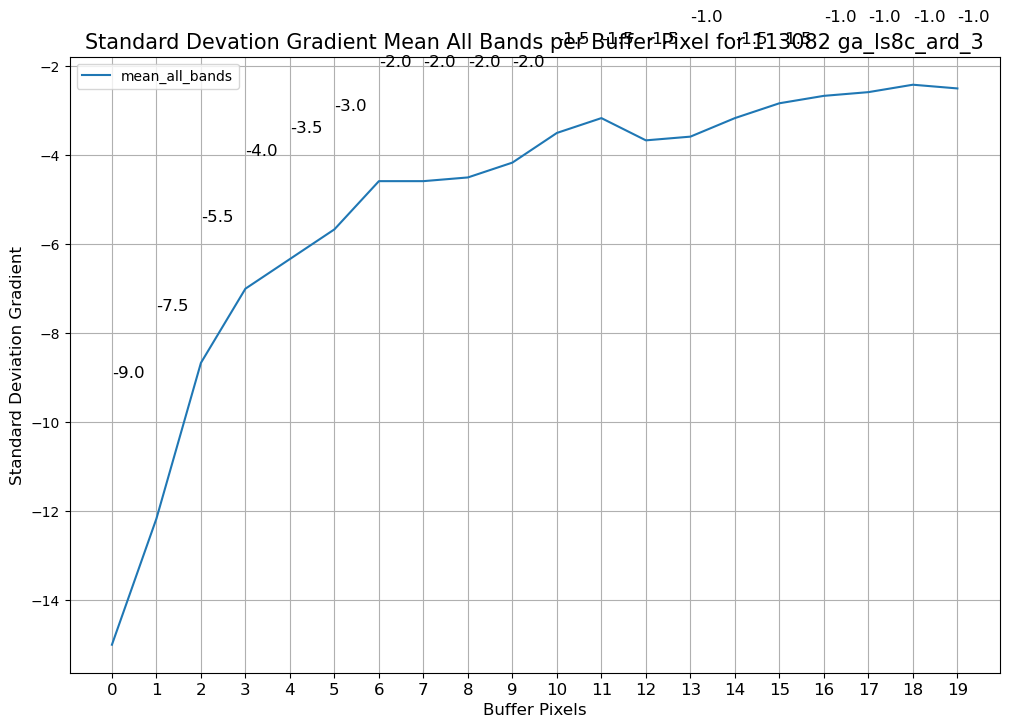

Error - possibly no data for ga_ls9c_ard_3. 'Dataset' object has no attribute 'oa_fmask'
Error - possibly no data for ga_ls5t_ard_3. 'Dataset' object has no attribute 'oa_fmask'
Buffer in pixels: 0, nbart_blue_std: 480, nbart_red_std: 784, nbart_green_std: 615, nbart_nir_std: 996, nbart_swir_1_std: 1200, nbart_swir_2_std: 1010
Buffer in pixels: 1, nbart_blue_std: 422, nbart_red_std: 729, nbart_green_std: 559, nbart_nir_std: 933, nbart_swir_1_std: 1136, nbart_swir_2_std: 959
Buffer in pixels: 2, nbart_blue_std: 379, nbart_red_std: 670, nbart_green_std: 507, nbart_nir_std: 855, nbart_swir_1_std: 1055, nbart_swir_2_std: 890
Buffer in pixels: 3, nbart_blue_std: 362, nbart_red_std: 647, nbart_green_std: 487, nbart_nir_std: 823, nbart_swir_1_std: 1021, nbart_swir_2_std: 861
Buffer in pixels: 4, nbart_blue_std: 352, nbart_red_std: 632, nbart_green_std: 475, nbart_nir_std: 803, nbart_swir_1_std: 1000, nbart_swir_2_std: 842
Buffer in pixels: 5, nbart_blue_std: 341, nbart_red_std: 616, nbart_gre

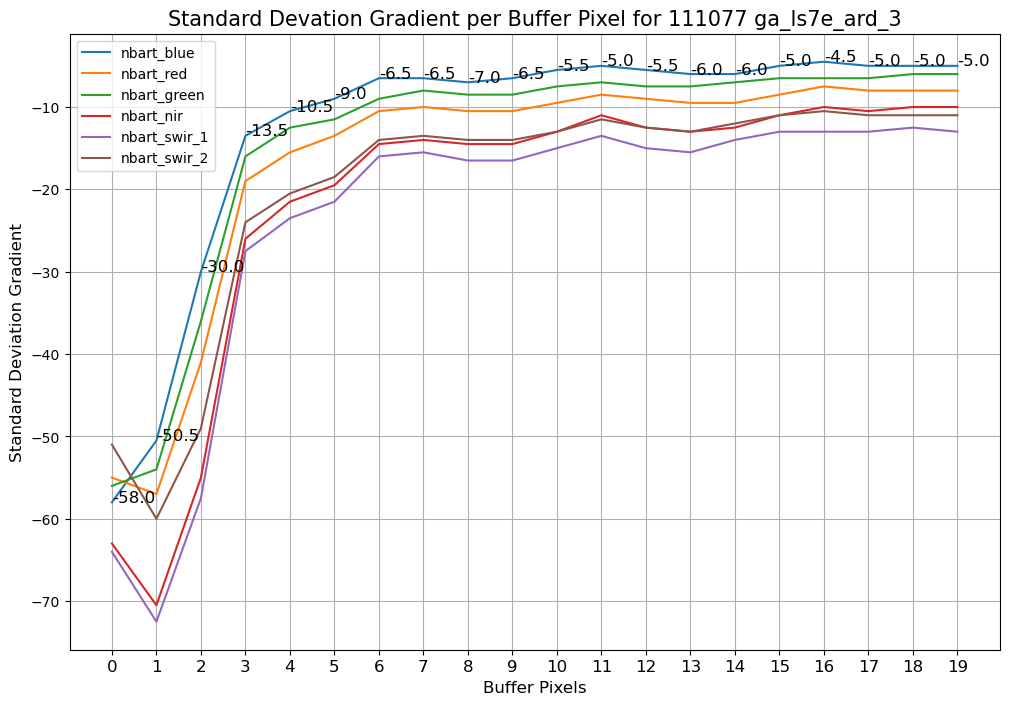

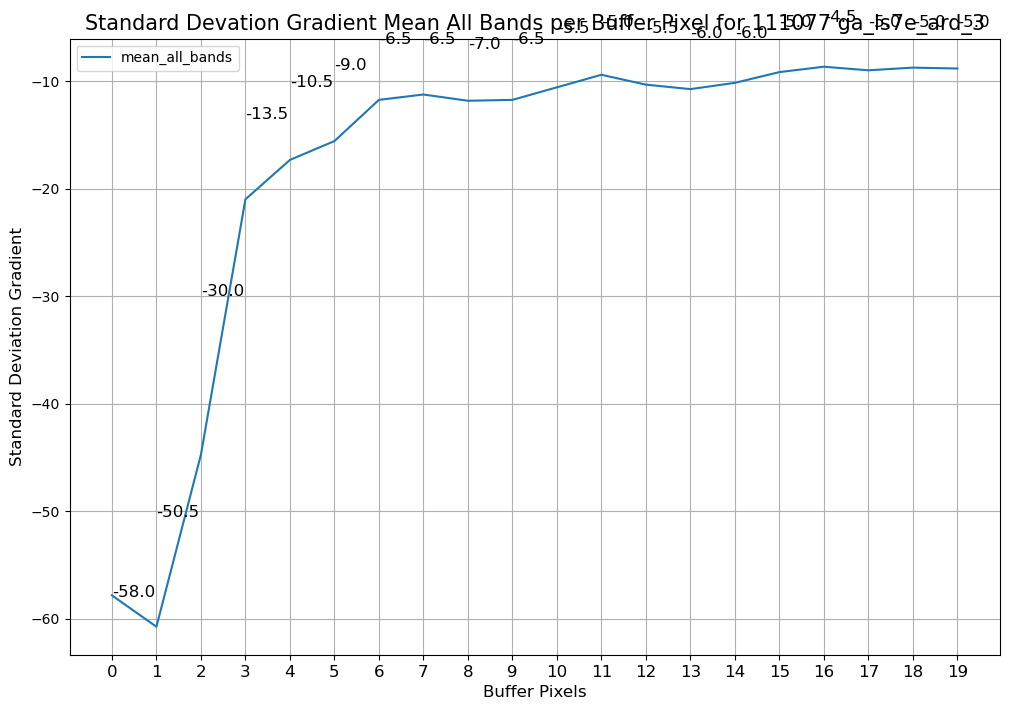

Buffer in pixels: 0, nbart_blue_std: 102, nbart_red_std: 238, nbart_green_std: 140, nbart_nir_std: 201, nbart_swir_1_std: 296, nbart_swir_2_std: 274
Buffer in pixels: 1, nbart_blue_std: 93, nbart_red_std: 226, nbart_green_std: 130, nbart_nir_std: 180, nbart_swir_1_std: 275, nbart_swir_2_std: 257
Buffer in pixels: 2, nbart_blue_std: 87, nbart_red_std: 218, nbart_green_std: 123, nbart_nir_std: 167, nbart_swir_1_std: 263, nbart_swir_2_std: 247
Buffer in pixels: 3, nbart_blue_std: 82, nbart_red_std: 211, nbart_green_std: 117, nbart_nir_std: 156, nbart_swir_1_std: 252, nbart_swir_2_std: 239
Buffer in pixels: 4, nbart_blue_std: 79, nbart_red_std: 206, nbart_green_std: 112, nbart_nir_std: 148, nbart_swir_1_std: 244, nbart_swir_2_std: 232
Buffer in pixels: 5, nbart_blue_std: 75, nbart_red_std: 200, nbart_green_std: 108, nbart_nir_std: 139, nbart_swir_1_std: 234, nbart_swir_2_std: 225
Buffer in pixels: 6, nbart_blue_std: 73, nbart_red_std: 196, nbart_green_std: 105, nbart_nir_std: 133, nbart_sw

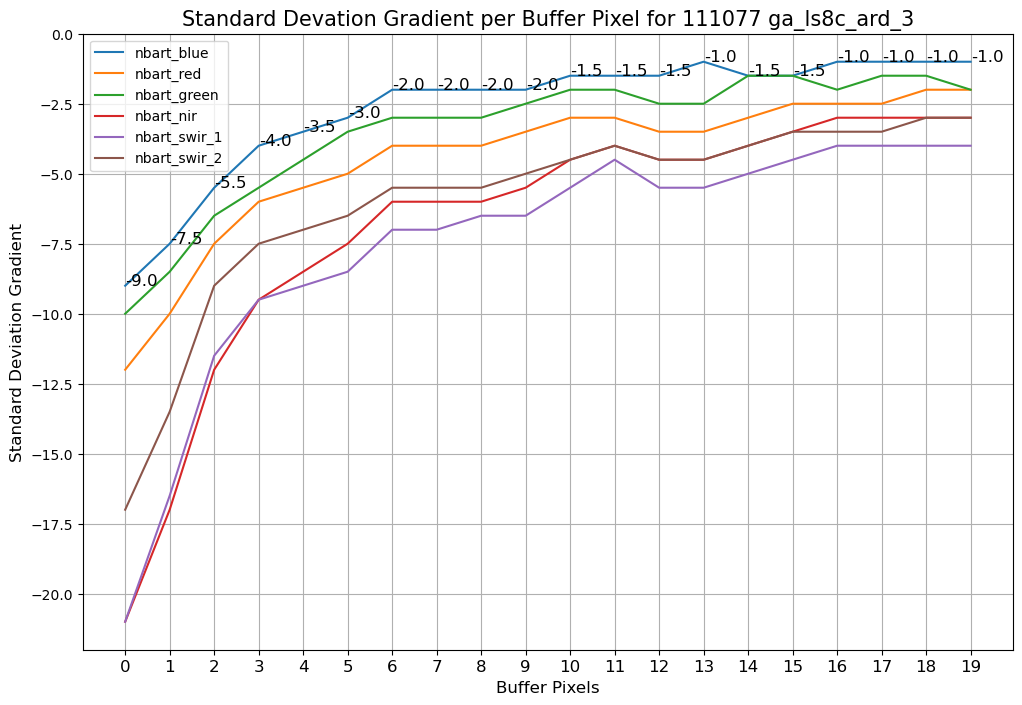

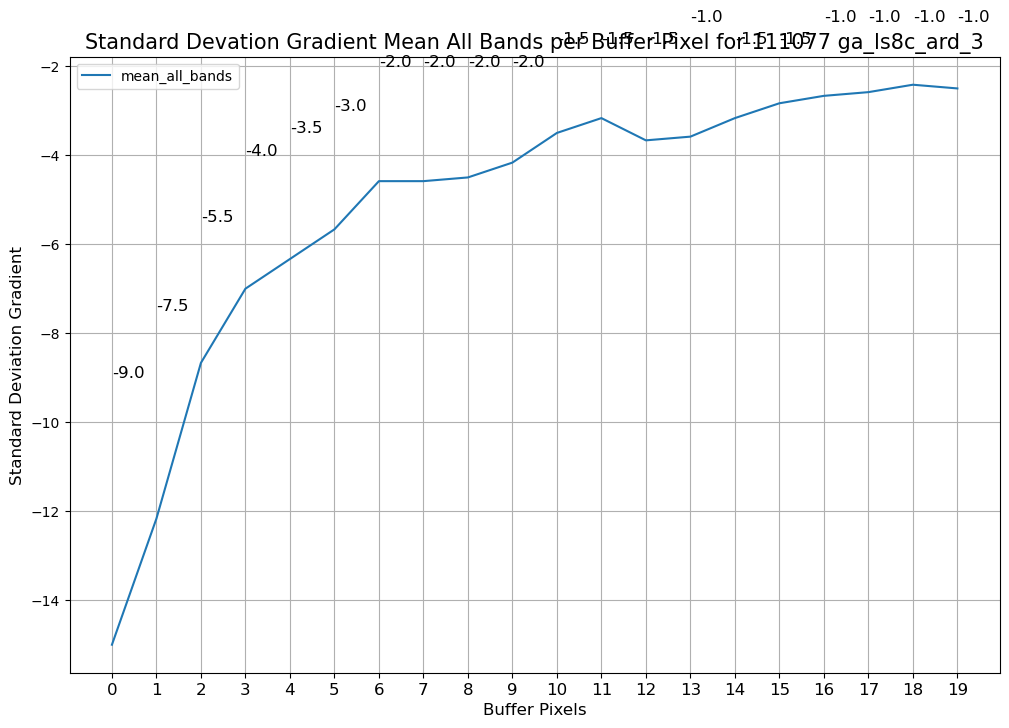

Error - possibly no data for ga_ls9c_ard_3. 'Dataset' object has no attribute 'oa_fmask'


In [48]:
for path_row in path_row_list:
    for product in products:
        # Full path-rows
        #query_param = query_params(landsat_shape, path_row, time_period)

        # Small test area
        query_param = query_params_lat_lon_test(time_period)

        # Load Data
        ds = load_data(bands, product, query_param)

        try:
            # Calculate cloud shadow mask
            cloud_shadow_mask = calc_cloud_shadow_mask(ds)

            # Calculate standard deviation per buffer in pixels
            std_buffer_df = std_buffer_comp(start_buffering, end_buffering, ds, cloud_shadow_mask, path_row)

            # Export result as csv
            std_buffer_df.to_csv(f"output_data/{path_row}_{product}_std_buffer.csv", index=True)

            # Plot the standard deviation results
            # plot_std_vs_buffer(std_buffer_df, path_row)
            plot_gradient_std(std_buffer_df, path_row, product)
        except Exception as e:
            print(f'Error - possibly no data for {product}. {e}')
            

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** June 2023

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.8.13


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)